# SLC

## Imports

In [1]:
import os
import optuna
import time
import spectral
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,recall_score,cohen_kappa_score,accuracy_score
from torchmetrics.classification import MulticlassConfusionMatrix
from torchinfo import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.decomposition import PCA
from pytorch_wavelets import DWTForward
from tqdm import tqdm
import random
from torchviz import make_dot
import h5py
import gc
import matplotlib.patches as mpatches

import hypso 
from hypso import Hypso1, Hypso2




from torch.utils.data import ConcatDataset
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

start_time = time.time() 

# Device
torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Is CUDA available?:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available.")

print("Allocated GPU memory:", torch.cuda.memory_allocated())
print("Cached GPU memory:", torch.cuda.memory_reserved())


c:\Users\Philip Shahdadfar\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'hypso'

## Settings

In [ ]:
DATASET = 'SLC'    


if DATASET == 'SLC':
    N_PCA = 80
    TRAIN_SIZE = 0.9
    BATCH_SIZE = 16
    EPOCH = 50
    PATCH_SIZE = 128
    LR = 0.001   
    WEIGHT_DECAY = 0.0001
    

VAL_EPOCH = 5
VAL_RATE = 0.1    
RANDOM_SEED=42

print(f'Number of bands utilized: {N_PCA}') 
print(f'Training size: {TRAIN_SIZE}') 
print(f'Epochs: {EPOCH}') 
print(f'Batch size: {BATCH_SIZE}') 
print(f'Patch size: {PATCH_SIZE}') 
print(f'Learning rate: {LR}') 
print(f'Weight decay: {WEIGHT_DECAY}') 


Number of bands utilized: 80
Training size: 0.9
Epochs: 50
Batch size: 16
Patch size: 128
Learning rate: 0.001
Weight decay: 0.0001


In [ ]:
## Set random seed for reproduction
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



SAVE_PATH = f"results\\{DATASET}"
if not os.path.isdir(SAVE_PATH):
    os.mkdir(SAVE_PATH)

## Dataset

In [ ]:
def load_dataset(dataset_name, ignore_scenes=None):
    if ignore_scenes is None:
        ignore_scenes = []  # Default to an empty list if no scenes are specified
    
    datapath = os.path.join(os.getcwd(), 'Datasets')
    
    if dataset_name == 'SLC':
        dataset_path = os.path.join(datapath, 'SLC')
        
        # Get all .mat and _class_NPY_FORMAT.npy files
        data_files = [f for f in os.listdir(dataset_path) if f.endswith('.mat')]
        label_files = [f for f in os.listdir(dataset_path) if f.endswith('_class_NPY_FORMAT.npy')]
        
        # Extract scene names from filenames
        data_scenes = {os.path.splitext(f)[0]: f for f in data_files}
        label_scenes = {f.replace('_class_NPY_FORMAT.npy', ''): f for f in label_files}
        
        # Ensure data and label files are matched correctly based on scene names
        common_scenes = sorted(set(data_scenes.keys()) & set(label_scenes.keys()))

        # Filter out ignored scenes
        common_scenes = [scene for scene in common_scenes if scene not in ignore_scenes]
        
        data_list = []
        label_list = []
        class_name = ["Sea", "Land", "Cloud"]
        
        for scene in common_scenes:
            data_path = os.path.join(dataset_path, data_scenes[scene])
            label_path = os.path.join(dataset_path, label_scenes[scene])
            
            # Load the .mat file and find the correct key
            mat_contents = sio.loadmat(data_path)
            available_keys = [key for key in mat_contents.keys() if not key.startswith('__')]
            
            if scene in mat_contents:
                data_list.append(mat_contents[scene])
            elif len(available_keys) == 1:
                data_list.append(mat_contents[available_keys[0]])  # Use the only available key
            else:
                raise KeyError(f"Key '{scene}' not found in {data_path}. Available keys: {available_keys}")
            
            # Load the .npy label file
            label_list.append(np.load(label_path))
        
        return np.array(data_list), np.array(label_list), class_name, common_scenes
    else:
        raise ValueError(f"Dataset {dataset_name} not recognized.")
    


ignore_scenes = ["Niger_2022_09_06T09_26_29", "griegFinnmark_2022_07_06", "erie_2022-09-21", "palliserIslands_2022-10-22"]
data_list, label_list, class_name, common_scenes = load_dataset(DATASET, ignore_scenes)

print(f"Number of images: {len(data_list)}")
print(f"Number of labels: {len(label_list)}")
for scene, data in zip(common_scenes, data_list):
    pass
print(f"Data Shape: {data.shape}")
for scene, label in zip(common_scenes, label_list):
    pass
print(f"Labels Shape: {label.shape}")

unique_labels = np.unique(np.concatenate(label_list))
print(f"Unique labels in dataset: {unique_labels}")

# Adjust if labels are zero-indexed
NUM_CLASS = unique_labels.max() + 1 if 0 in unique_labels else unique_labels.max()
print(f"Number of classes: {NUM_CLASS}")

print(data_list.shape)
print(label_list.shape)

Number of images: 33
Number of labels: 33
Data Shape: (956, 684, 120)
Labels Shape: (956, 684)
Unique labels in dataset: [0 1 2]
Number of classes: 3
(33, 956, 684, 120)
(33, 956, 684)


## Pre-process data

### Dimensionality Reduction (PCA)

In [ ]:
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)   ##PCA and normalization
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

### Create image patches (zero-padding)

In [ ]:
class PatchSet(Dataset):
    """ Generate 3D patch from hyperspectral dataset """
    def __init__(self, data, gt, patch_size, is_pred=False):
        """
        Args:
            data: 3D hyperspectral image
            gt: 2D array of labels
            patch_size: int, size of the 3D patch
            is_pred: bool, create data without label for prediction (default False) 

        """
        super(PatchSet, self).__init__()
        self.is_pred = is_pred
        self.patch_size = patch_size
        p = self.patch_size // 2
        self.data = np.pad(data,((p,p),(p,p),(0,0)),'constant',constant_values = 0)
        if is_pred:
            gt = np.ones_like(gt)
        self.label = np.pad(gt,(p,p),'constant',constant_values = 0)
        x_pos, y_pos = np.nonzero(gt)
        x_pos, y_pos = x_pos + p, y_pos + p   ##indices after padding
        self.indices = np.array([(x,y) for x,y in zip(x_pos, y_pos)])
        if not is_pred:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        x, y = self.indices[i]
        x1, y1 = x - self.patch_size // 2, y - self.patch_size // 2
        x2, y2 = x1 + self.patch_size, y1 + self.patch_size
        data = self.data[x1:x2, y1:y2]
        label = self.label[x, y]
        data = np.asarray(data, dtype='float32').transpose((2, 0, 1))
        label = np.asarray(label, dtype='int64')
        data = torch.from_numpy(data)
        label = torch.from_numpy(label)
        if self.is_pred:
            return data
        else: return data, label

## Print 

In [ ]:
# class_names = {0: "Water", 1: "Land", 2: "Clouds"}  # Modify as needed

# for data, label, scene in zip(data_list, label_list, common_scenes):
#     fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 

#     rgb_data_1 = spectral.get_rgb(data, (29, 20, 10))  
#     rgb_data_2 = spectral.get_rgb(data, (0, 10, 20)) 

#     axes[0].imshow(rgb_data_1)
#     axes[0].set_title(f'RGB Origin - {scene}')
#     axes[0].axis('off')

#     # GroundTruth with color legend
#     im = axes[1].imshow(label, cmap='jet')
#     axes[1].set_title(f'GroundTruth - {scene}')
#     axes[1].axis('off')

#     axes[2].imshow(rgb_data_2)
#     axes[2].imshow(label, cmap='jet', alpha=0.5)
#     axes[2].set_title(f'Overlay - {scene}')
#     axes[2].axis('off')

#     # Extract unique labels present in the current label image
#     unique_labels = np.unique(label)

#     # Create legend with corresponding colors
#     patches = [
#         mpatches.Patch(color=plt.cm.jet(label_val / max(unique_labels)), label=class_names.get(label_val, f"Class {label_val}"))
#         for label_val in unique_labels
#     ]
    
#     # Add legend below GroundTruth
#     legend = axes[1].legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)
    
#     plt.suptitle(f'Scene: {scene}', fontsize=14, fontweight='bold')
    
#     plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit suptitle
#     plt.show()

## Apply Transformations

In [ ]:
data,pca = applyPCA(data,N_PCA)
print('Image shape:' + str(data.shape))


Image shape:(83, 86, 50)


### Data Split

### Create dataset and dataloader

In [ ]:
train_data = PatchSet(data, train_gt, PATCH_SIZE)
val_data = PatchSet(data, val_gt, PATCH_SIZE)
all_data = PatchSet(data, labels, PATCH_SIZE,is_pred = True)
train_loader = DataLoader(train_data,BATCH_SIZE,shuffle= True)
val_loader = DataLoader(val_data,BATCH_SIZE,shuffle= True)
all_loader = DataLoader(all_data,BATCH_SIZE,shuffle= False)

In [ ]:
d,g=train_data.__getitem__(0)
d.shape,g

(torch.Size([50, 50, 50]), tensor(11))

## Model

In [ ]:
class WaveletCNN(nn.Module):
    def __init__(self, in_channels, class_nums, levels=4):
        super(WaveletCNN, self).__init__()
        self.levels = levels
        self.dwt = nn.ModuleList([DWTForward(J=1, mode='zero', wave='db1') for _ in range(levels)])

        self.projections = nn.ModuleList()
        self.conv_blocks = nn.ModuleList()

        for i in range(levels):
            input_channels = in_channels + 3 * in_channels + sum(64 * (j + 1) for j in range(i))
            output_channels = 64 * (i + 1)
            
            
            self.projections.append(nn.Conv2d(input_channels, output_channels, kernel_size=1))

            
            self.conv_blocks.append(nn.Sequential(
                nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True)
            ))

    
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(sum(64 * (i + 1) for i in range(levels)), class_nums)

    def forward(self, x):
        features = []
        low_pass = x

        for i in range(self.levels):
          
            low_pass, high_pass = self.dwt[i](low_pass)
            batch_size, channels, height, width = low_pass.shape
            _, high_pass_channels, subbands, _, _ = high_pass[0].shape

           
            high_pass = high_pass[0].view(batch_size, high_pass_channels * subbands, height, width)

            
            resized_features = [
                F.interpolate(feat, size=(height, width), mode='bilinear', align_corners=False)
                for feat in features
            ]

            
            concatenated = torch.cat([low_pass, high_pass] + resized_features, dim=1)

            
            projected = self.projections[i](concatenated)
            conv_out = self.conv_blocks[i](projected)

            
            features.append(conv_out)

       
        smallest_height, smallest_width = features[-1].shape[2:]
        resized_features = [
            F.interpolate(feat, size=(smallest_height, smallest_width), mode='bilinear', align_corners=False)
            for feat in features
        ]

        
        out = torch.cat(resized_features, dim=1)

       
        out = self.global_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out






In [ ]:
# Initialize the model
net = WaveletCNN(in_channels=N_PCA, class_nums=NUM_CLASS)

# Input tensor
input_tensor = torch.randn(1, N_PCA, PATCH_SIZE, PATCH_SIZE)
print(f"Input tensor shape: {input_tensor.shape}")

# Model summary
summary(
    net,
    input_size=(1, N_PCA, PATCH_SIZE, PATCH_SIZE),
    col_names=['num_params', 'kernel_size', 'mult_adds', 'input_size', 'output_size'],
    col_width=18,
    row_settings=['var_names'],
    depth=4,
)

Input tensor shape: torch.Size([1, 50, 50, 50])


Layer (type (var_name))                  Param #            Kernel Shape       Mult-Adds          Input Shape        Output Shape
WaveletCNN (WaveletCNN)                  --                 --                 --                 [1, 50, 50, 50]    [1, 14]
├─ModuleList (dwt)                       --                 --                 --                 --                 --
│    └─DWTForward (0)                    --                 --                 --                 [1, 50, 50, 50]    [1, 50, 25, 25]
├─ModuleList (projections)               (recursive)        --                 --                 --                 --
│    └─Conv2d (0)                        12,864             [1, 1]             8,040,000          [1, 200, 25, 25]   [1, 64, 25, 25]
├─ModuleList (conv_blocks)               (recursive)        --                 --                 --                 --
│    └─Sequential (0)                    --                 --                 --                 [1, 64, 25, 25]    [1

## Training

Training::   1%|          | 1/100 [00:00<00:59,  1.67it/s]

epoch 0/100 loss:0.009568143649940634  acc:0.45131086142322097


Training::   2%|▏         | 2/100 [00:01<00:47,  2.06it/s]

epoch 1/100 loss:0.003984945208838816  acc:0.8014981273408239


Training::   3%|▎         | 3/100 [00:01<00:45,  2.15it/s]

epoch 2/100 loss:0.0025990245382437544  acc:0.8857677902621723


Training::   4%|▍         | 4/100 [00:01<00:43,  2.20it/s]

epoch 3/100 loss:0.002087190468213085  acc:0.9531835205992509


100%|██████████| 3/3 [00:00<00:00,  6.99it/s]


epoch 4/100 loss:0.001685771993483497  acc:0.9794007490636704


Training::   5%|▌         | 5/100 [00:02<00:57,  1.67it/s]

epoch 4/100  val_acc:0.9719101123595506
Epoch 5/100 completed in 0.86 seconds.


Training::   6%|▌         | 6/100 [00:03<00:51,  1.83it/s]

epoch 5/100 loss:0.0017356206192059463  acc:0.9794007490636704


Training::   7%|▋         | 7/100 [00:03<00:47,  1.97it/s]

epoch 6/100 loss:0.0011408782183900755  acc:0.9775280898876404


Training::   8%|▊         | 8/100 [00:04<00:44,  2.05it/s]

epoch 7/100 loss:0.0012076988760451699  acc:0.9700374531835206


Training::   9%|▉         | 9/100 [00:04<00:42,  2.13it/s]

epoch 8/100 loss:0.0009836938218231058  acc:0.9756554307116105


100%|██████████| 3/3 [00:00<00:00,  6.92it/s]


epoch 9/100 loss:0.000855366640099872  acc:0.9868913857677902


Training::  10%|█         | 10/100 [00:05<00:53,  1.70it/s]

epoch 9/100  val_acc:0.9794007490636704
Epoch 10/100 completed in 0.86 seconds.


Training::  11%|█         | 11/100 [00:05<00:48,  1.85it/s]

epoch 10/100 loss:0.0006303524507788683  acc:0.9887640449438202


Training::  12%|█▏        | 12/100 [00:06<00:44,  1.96it/s]

epoch 11/100 loss:0.0005357105577929636  acc:0.9943820224719101


Training::  13%|█▎        | 13/100 [00:06<00:42,  2.06it/s]

epoch 12/100 loss:0.0004909113886651028  acc:0.99812734082397


Training::  14%|█▍        | 14/100 [00:07<00:40,  2.11it/s]

epoch 13/100 loss:0.0005232494477922104  acc:0.9962546816479401


100%|██████████| 3/3 [00:00<00:00,  6.75it/s]


epoch 14/100 loss:0.00043738623627562645  acc:1.0


Training::  15%|█▌        | 15/100 [00:07<00:50,  1.68it/s]

epoch 14/100  val_acc:0.9831460674157303
Epoch 15/100 completed in 0.87 seconds.


Training::  16%|█▌        | 16/100 [00:08<00:46,  1.81it/s]

epoch 15/100 loss:0.0004939129401682022  acc:0.9962546816479401


Training::  17%|█▋        | 17/100 [00:08<00:42,  1.94it/s]

epoch 16/100 loss:0.00030249212118570277  acc:1.0


Training::  18%|█▊        | 18/100 [00:09<00:40,  2.03it/s]

epoch 17/100 loss:0.0003624987833843696  acc:0.99812734082397


Training::  19%|█▉        | 19/100 [00:09<00:38,  2.10it/s]

epoch 18/100 loss:0.0002622056250156981  acc:1.0


100%|██████████| 3/3 [00:00<00:00,  6.78it/s]


epoch 19/100 loss:0.0002478128752570027  acc:0.99812734082397


Training::  20%|██        | 20/100 [00:10<00:47,  1.69it/s]

epoch 19/100  val_acc:0.951310861423221
Epoch 20/100 completed in 0.87 seconds.


Training::  21%|██        | 21/100 [00:11<00:43,  1.83it/s]

epoch 20/100 loss:0.00019889822306481193  acc:1.0


Training::  22%|██▏       | 22/100 [00:11<00:40,  1.95it/s]

epoch 21/100 loss:0.00015368348873509897  acc:1.0


Training::  23%|██▎       | 23/100 [00:11<00:37,  2.03it/s]

epoch 22/100 loss:0.00011222895185989834  acc:1.0


Training::  24%|██▍       | 24/100 [00:12<00:36,  2.11it/s]

epoch 23/100 loss:0.00013676593045282008  acc:1.0


100%|██████████| 3/3 [00:00<00:00,  6.85it/s]


epoch 24/100 loss:9.422401691811361e-05  acc:1.0


Training::  25%|██▌       | 25/100 [00:13<00:44,  1.69it/s]

epoch 24/100  val_acc:0.9925093632958801
Epoch 25/100 completed in 0.87 seconds.


Training::  26%|██▌       | 26/100 [00:13<00:40,  1.85it/s]

epoch 25/100 loss:0.00011219508764560749  acc:1.0


Training::  27%|██▋       | 27/100 [00:14<00:37,  1.95it/s]

epoch 26/100 loss:0.00010064626566033238  acc:1.0


Training::  28%|██▊       | 28/100 [00:14<00:35,  2.05it/s]

epoch 27/100 loss:9.335713872637195e-05  acc:1.0


Training::  29%|██▉       | 29/100 [00:14<00:33,  2.13it/s]

epoch 28/100 loss:0.0001178352033182253  acc:1.0


100%|██████████| 3/3 [00:00<00:00,  7.06it/s]


epoch 29/100 loss:6.901709125673727e-05  acc:1.0


Training::  30%|███       | 30/100 [00:15<00:40,  1.71it/s]

epoch 29/100  val_acc:0.9887640449438202
Epoch 30/100 completed in 0.85 seconds.


Training::  31%|███       | 31/100 [00:16<00:37,  1.86it/s]

epoch 30/100 loss:5.649459942449791e-05  acc:1.0


Training::  32%|███▏      | 32/100 [00:16<00:33,  2.01it/s]

epoch 31/100 loss:6.760258318277333e-05  acc:1.0


Training::  33%|███▎      | 33/100 [00:17<00:31,  2.12it/s]

epoch 32/100 loss:4.49251008572315e-05  acc:1.0


Training::  34%|███▍      | 34/100 [00:17<00:29,  2.22it/s]

epoch 33/100 loss:0.0003899671093731672  acc:0.9962546816479401


100%|██████████| 3/3 [00:00<00:00,  7.41it/s]


epoch 34/100 loss:0.00019324149183008109  acc:0.99812734082397


Training::  35%|███▌      | 35/100 [00:18<00:36,  1.79it/s]

epoch 34/100  val_acc:0.9269662921348315
Epoch 35/100 completed in 0.81 seconds.


Training::  36%|███▌      | 36/100 [00:18<00:33,  1.93it/s]

epoch 35/100 loss:0.00014766753208213086  acc:0.99812734082397


Training::  37%|███▋      | 37/100 [00:19<00:30,  2.03it/s]

epoch 36/100 loss:0.00013560819533768665  acc:1.0


Training::  38%|███▊      | 38/100 [00:19<00:29,  2.13it/s]

epoch 37/100 loss:0.00010911019846852799  acc:1.0


Training::  39%|███▉      | 39/100 [00:19<00:27,  2.22it/s]

epoch 38/100 loss:7.407016152243936e-05  acc:1.0


100%|██████████| 3/3 [00:00<00:00,  6.97it/s]


epoch 39/100 loss:7.332319547230385e-05  acc:1.0


Training::  40%|████      | 40/100 [00:20<00:34,  1.76it/s]

epoch 39/100  val_acc:0.9756554307116105
Epoch 40/100 completed in 0.84 seconds.


Training::  41%|████      | 41/100 [00:21<00:30,  1.92it/s]

epoch 40/100 loss:0.00010279352577884546  acc:1.0


Training::  42%|████▏     | 42/100 [00:21<00:28,  2.06it/s]

epoch 41/100 loss:4.310401379783055e-05  acc:1.0


Training::  43%|████▎     | 43/100 [00:21<00:26,  2.18it/s]

epoch 42/100 loss:8.146575746241581e-05  acc:0.9962546816479401


Training::  44%|████▍     | 44/100 [00:22<00:25,  2.23it/s]

epoch 43/100 loss:5.099628720613901e-05  acc:1.0


100%|██████████| 3/3 [00:00<00:00,  7.83it/s]


epoch 44/100 loss:3.548284943742252e-05  acc:1.0


Training::  45%|████▌     | 45/100 [00:23<00:30,  1.82it/s]

epoch 44/100  val_acc:0.9868913857677902
Epoch 45/100 completed in 0.78 seconds.


Training::  46%|████▌     | 46/100 [00:23<00:27,  1.99it/s]

epoch 45/100 loss:7.454721232673871e-05  acc:1.0


Training::  47%|████▋     | 47/100 [00:23<00:25,  2.09it/s]

epoch 46/100 loss:4.024243536876159e-05  acc:1.0


Training::  48%|████▊     | 48/100 [00:24<00:23,  2.19it/s]

epoch 47/100 loss:3.23036638496632e-05  acc:1.0


Training::  49%|████▉     | 49/100 [00:24<00:22,  2.27it/s]

epoch 48/100 loss:3.859869288175963e-05  acc:1.0


100%|██████████| 3/3 [00:00<00:00,  7.53it/s]


epoch 49/100 loss:2.659776261990213e-05  acc:1.0


Training::  50%|█████     | 50/100 [00:25<00:27,  1.84it/s]

epoch 49/100  val_acc:0.9906367041198502
Epoch 50/100 completed in 0.78 seconds.


Training::  51%|█████     | 51/100 [00:25<00:24,  2.01it/s]

epoch 50/100 loss:2.156222833857666e-05  acc:1.0


Training::  52%|█████▏    | 52/100 [00:26<00:22,  2.13it/s]

epoch 51/100 loss:4.966734439371789e-05  acc:1.0


Training::  53%|█████▎    | 53/100 [00:26<00:20,  2.24it/s]

epoch 52/100 loss:2.4989689002685557e-05  acc:1.0


Training::  54%|█████▍    | 54/100 [00:27<00:20,  2.30it/s]

epoch 53/100 loss:3.233738069174888e-05  acc:1.0


100%|██████████| 3/3 [00:00<00:00,  6.93it/s]


epoch 54/100 loss:2.8892394943574393e-05  acc:1.0


Training::  55%|█████▌    | 55/100 [00:28<00:25,  1.76it/s]

epoch 54/100  val_acc:0.9868913857677902
Epoch 55/100 completed in 0.88 seconds.


Training::  56%|█████▌    | 56/100 [00:28<00:23,  1.90it/s]

epoch 55/100 loss:1.580116848290413e-05  acc:1.0


Training::  57%|█████▋    | 57/100 [00:28<00:21,  2.04it/s]

epoch 56/100 loss:1.512951050162985e-05  acc:1.0


Training::  58%|█████▊    | 58/100 [00:29<00:19,  2.14it/s]

epoch 57/100 loss:4.557919930945733e-05  acc:1.0


Training::  59%|█████▉    | 59/100 [00:29<00:18,  2.23it/s]

epoch 58/100 loss:1.4800910161257013e-05  acc:1.0


100%|██████████| 3/3 [00:00<00:00,  7.55it/s]


epoch 59/100 loss:9.39350522887171e-05  acc:1.0


Training::  60%|██████    | 60/100 [00:30<00:22,  1.80it/s]

epoch 59/100  val_acc:0.9812734082397003
Epoch 60/100 completed in 0.81 seconds.


Training::  61%|██████    | 61/100 [00:30<00:19,  1.97it/s]

epoch 60/100 loss:5.6813530752972496e-05  acc:1.0


Training::  62%|██████▏   | 62/100 [00:31<00:18,  2.10it/s]

epoch 61/100 loss:3.0279756882943018e-05  acc:1.0


Training::  63%|██████▎   | 63/100 [00:31<00:17,  2.17it/s]

epoch 62/100 loss:3.5968851577141755e-05  acc:1.0


Training::  64%|██████▍   | 64/100 [00:32<00:15,  2.25it/s]

epoch 63/100 loss:2.0951768191538277e-05  acc:1.0


100%|██████████| 3/3 [00:00<00:00,  7.24it/s]


epoch 64/100 loss:1.7884734159942424e-05  acc:1.0


Training::  65%|██████▌   | 65/100 [00:32<00:19,  1.77it/s]

epoch 64/100  val_acc:0.9775280898876404
Epoch 65/100 completed in 0.85 seconds.


Training::  66%|██████▌   | 66/100 [00:33<00:17,  1.89it/s]

epoch 65/100 loss:1.6526375768169036e-05  acc:1.0


Training::  67%|██████▋   | 67/100 [00:33<00:16,  2.04it/s]

epoch 66/100 loss:1.064517137625914e-05  acc:1.0


Training::  68%|██████▊   | 68/100 [00:34<00:14,  2.16it/s]

epoch 67/100 loss:1.976911234930995e-05  acc:1.0


Training::  69%|██████▉   | 69/100 [00:34<00:13,  2.25it/s]

epoch 68/100 loss:1.113291233359428e-05  acc:1.0


100%|██████████| 3/3 [00:00<00:00,  7.13it/s]


epoch 69/100 loss:8.911238843749525e-06  acc:1.0


Training::  70%|███████   | 70/100 [00:35<00:16,  1.80it/s]

epoch 69/100  val_acc:0.9812734082397003
Epoch 70/100 completed in 0.81 seconds.


Training::  71%|███████   | 71/100 [00:35<00:14,  1.95it/s]

epoch 70/100 loss:1.2050150616324685e-05  acc:1.0


Training::  72%|███████▏  | 72/100 [00:36<00:13,  2.07it/s]

epoch 71/100 loss:8.78906183551704e-06  acc:1.0


Training::  73%|███████▎  | 73/100 [00:36<00:12,  2.16it/s]

epoch 72/100 loss:1.0530669931043289e-05  acc:1.0


Training::  74%|███████▍  | 74/100 [00:37<00:11,  2.23it/s]

epoch 73/100 loss:1.1842492714956794e-05  acc:1.0


100%|██████████| 3/3 [00:00<00:00,  7.46it/s]


epoch 74/100 loss:2.2572179652806303e-05  acc:1.0


Training::  75%|███████▌  | 75/100 [00:37<00:13,  1.80it/s]

epoch 74/100  val_acc:0.9850187265917603
Epoch 75/100 completed in 0.81 seconds.


Training::  76%|███████▌  | 76/100 [00:38<00:12,  1.95it/s]

epoch 75/100 loss:1.1237317910731844e-05  acc:1.0


Training::  77%|███████▋  | 77/100 [00:38<00:10,  2.10it/s]

epoch 76/100 loss:1.1646163506844964e-05  acc:1.0


Training::  78%|███████▊  | 78/100 [00:39<00:10,  2.17it/s]

epoch 77/100 loss:2.730759240038107e-05  acc:1.0


Training::  79%|███████▉  | 79/100 [00:39<00:09,  2.27it/s]

epoch 78/100 loss:2.03865020420779e-05  acc:1.0


100%|██████████| 3/3 [00:00<00:00,  7.43it/s]


epoch 79/100 loss:1.876392795910103e-05  acc:1.0


Training::  80%|████████  | 80/100 [00:40<00:10,  1.82it/s]

epoch 79/100  val_acc:0.9700374531835206
Epoch 80/100 completed in 0.80 seconds.


Training::  81%|████████  | 81/100 [00:40<00:09,  1.98it/s]

epoch 80/100 loss:2.660350621179137e-05  acc:1.0


Training::  82%|████████▏ | 82/100 [00:41<00:08,  2.09it/s]

epoch 81/100 loss:2.391954922302162e-05  acc:1.0


Training::  83%|████████▎ | 83/100 [00:41<00:07,  2.20it/s]

epoch 82/100 loss:1.4987605456472112e-05  acc:1.0


Training::  84%|████████▍ | 84/100 [00:41<00:06,  2.29it/s]

epoch 83/100 loss:7.163252322219508e-06  acc:1.0


100%|██████████| 3/3 [00:00<00:00,  7.56it/s]


epoch 84/100 loss:9.861148846743817e-06  acc:1.0


Training::  85%|████████▌ | 85/100 [00:42<00:08,  1.82it/s]

epoch 84/100  val_acc:0.9681647940074907
Epoch 85/100 completed in 0.81 seconds.


Training::  86%|████████▌ | 86/100 [00:43<00:07,  1.95it/s]

epoch 85/100 loss:8.48319431180867e-06  acc:1.0


Training::  87%|████████▋ | 87/100 [00:43<00:06,  2.05it/s]

epoch 86/100 loss:8.34653994647528e-06  acc:1.0


Training::  88%|████████▊ | 88/100 [00:44<00:05,  2.17it/s]

epoch 87/100 loss:9.452575976412729e-06  acc:1.0


Training::  89%|████████▉ | 89/100 [00:44<00:04,  2.25it/s]

epoch 88/100 loss:5.030186545131693e-05  acc:1.0


100%|██████████| 3/3 [00:00<00:00,  7.64it/s]


epoch 89/100 loss:1.2213847890307896e-05  acc:1.0


Training::  90%|█████████ | 90/100 [00:45<00:05,  1.83it/s]

epoch 89/100  val_acc:0.9794007490636704
Epoch 90/100 completed in 0.78 seconds.


Training::  91%|█████████ | 91/100 [00:45<00:04,  1.99it/s]

epoch 90/100 loss:1.1835997873631198e-05  acc:1.0


Training::  92%|█████████▏| 92/100 [00:46<00:03,  2.12it/s]

epoch 91/100 loss:1.466501641962747e-05  acc:1.0


Training::  93%|█████████▎| 93/100 [00:46<00:03,  2.24it/s]

epoch 92/100 loss:3.4358188482036306e-05  acc:1.0


Training::  94%|█████████▍| 94/100 [00:46<00:02,  2.32it/s]

epoch 93/100 loss:7.228502238078622e-06  acc:1.0


100%|██████████| 3/3 [00:00<00:00,  7.62it/s]


epoch 94/100 loss:2.1837204598825188e-05  acc:1.0


Training::  95%|█████████▌| 95/100 [00:47<00:02,  1.87it/s]

epoch 94/100  val_acc:0.9400749063670412
Epoch 95/100 completed in 0.78 seconds.


Training::  96%|█████████▌| 96/100 [00:47<00:01,  2.03it/s]

epoch 95/100 loss:2.621181094705054e-05  acc:1.0


Training::  97%|█████████▋| 97/100 [00:48<00:01,  2.16it/s]

epoch 96/100 loss:1.3693520094683108e-05  acc:1.0


Training::  98%|█████████▊| 98/100 [00:48<00:00,  2.24it/s]

epoch 97/100 loss:7.5306376042925796e-06  acc:1.0


Training::  99%|█████████▉| 99/100 [00:49<00:00,  2.33it/s]

epoch 98/100 loss:6.726830138228415e-06  acc:1.0


100%|██████████| 3/3 [00:00<00:00,  7.66it/s]


epoch 99/100 loss:9.220681887482771e-06  acc:1.0


Training:: 100%|██████████| 100/100 [00:49<00:00,  2.00it/s]


epoch 99/100  val_acc:0.9719101123595506
Epoch 100/100 completed in 0.77 seconds.
Training completed in 49.93 seconds.
Stop in epoch 99


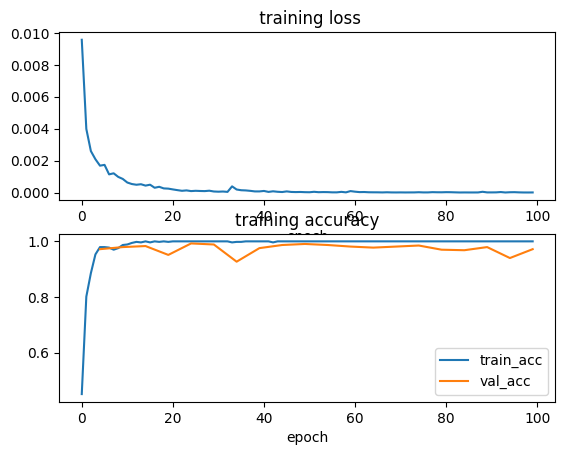

In [ ]:
## training the model
device = torch.device(DEVICE if DEVICE>=0 and torch.cuda.is_available() else 'cpu')
loss_list = []
acc_list = []
val_acc_list = []
val_epoch_list = []

model = WaveletCNN(N_PCA, class_nums=NUM_CLASS)
model.to(device)
#optimizer = torch.optim.SGD(model.parameters(), LR,weight_decay=WEIGHT_DECAY)
optimizer = torch.optim.Adam(model.parameters(),LR,weight_decay=WEIGHT_DECAY)
loss_func = nn.CrossEntropyLoss()
batch_num = len(train_loader)
train_num = train_loader.dataset.__len__()
val_num = val_loader.dataset.__len__()

fig = plt.figure()
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

e = -1


start_time = time.time()

try:
    for e in tqdm(range(EPOCH), desc="Training:"):
        epoch_start_time = time.time()
        model.train()
        avg_loss = 0.
        train_acc = 0
        for batch_idx, (data, target) in tqdm(enumerate(train_loader),total=batch_num):
            data,target = data.to(device),target.to(device)
            optimizer.zero_grad()
            out = model(data)
            target = target - 1  ## class 0 in out is class 1 in target
            loss = loss_func(out,target)
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()
            _,pred = torch.max(out,dim=1)
            train_acc += (pred == target).sum().item()
        loss_list.append(avg_loss/train_num)
        acc_list.append(train_acc/train_num)
        print(f"epoch {e}/{EPOCH} loss:{loss_list[e]}  acc:{acc_list[e]}")
        ## valuation
        if (e+1)%VAL_EPOCH == 0 or (e+1)==EPOCH:
            val_acc =0
            model.eval()
            for batch_idx, (data, target) in tqdm(enumerate(val_loader),total=len(val_loader)):
                data,target = data.to(device),target.to(device)
                out = model(data)
                target = target - 1  ## class 0 in out is class 1 in target
                _,pred = torch.max(out,dim=1)
                val_acc += (pred == target).sum().item()
            val_acc_list.append(val_acc/val_num)
            val_epoch_list.append(e)
            print(f"epoch {e}/{EPOCH}  val_acc:{val_acc_list[-1]}")
            save_name = os.path.join(SAVE_PATH, f"epoch_{e}_acc_{val_acc_list[-1]:.4f}.pth")
            torch.save(model.state_dict(),save_name)


            epoch_end_time = time.time()
            print(f"Epoch {e + 1}/{EPOCH} completed in {epoch_end_time - epoch_start_time:.2f} seconds.")



    ax1.plot(np.arange(e+1),loss_list)
    ax1.set_title(' training loss')
    ax1.set_xlabel('epoch')
    ax2.plot(np.arange(e+1),acc_list,label = 'train_acc')
    ax2.plot(val_epoch_list,val_acc_list,label = 'val_acc')
    ax2.set_title('training accuracy')
    ax2.set_xlabel('epoch')
    ax2.legend()
except Exception as exc:
    print(exc)
finally: 
    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f} seconds.")
    print(f'Stop in epoch {e}')

### Save Best Model

In [ ]:
## get best model path and del other models
def get_best_model(acc_list, epoch_list, save_path):
    """get best model path by valuation list

    Args:
        acc_list (list): list of valuation accuracy
        epoch_list (list): list of valuation epoch
        save_path (str): path of save dir

    Returns:
        best_model_path: path of best model
    """
    acc_list = np.array(acc_list)
    epoch_list = np.array(epoch_list)
    best_index = np.argwhere(acc_list==np.max(acc_list))[-1].item()
    best_epoch = epoch_list[best_index]
    best_acc = acc_list[best_index]
    file_name = f"epoch_{best_epoch}_acc_{best_acc:.4f}.pth"
    best_model_path=os.path.join(save_path, file_name)
    print(f"best model:{file_name}")
    ##del save model except best model
    for f in os.listdir(save_path):
        if f[-3:]=='pth' and os.path.join(save_path,f)!=best_model_path:
            os.remove(os.path.join(save_path,f))
    return best_model_path

### Load

In [ ]:
## inferring the whole image
##load best model
best_model_path = get_best_model(val_acc_list,val_epoch_list,SAVE_PATH)
best_model = WaveletCNN(N_PCA,class_nums=NUM_CLASS)
best_model.load_state_dict(torch.load(best_model_path))
## inference
best_model.to(device)
best_model.eval()
pred_map = []
for batch_idx, data in tqdm(enumerate(all_loader),total=len(all_loader)):
    data = data.to(device)
    target = best_model(data)
    _, pred = torch.max(target, dim = 1)
    pred_map += [np.array(pred.detach().cpu() + 1)]   ## class 0 in pred_map is class 1 in gt
pred_map = np.asarray(np.hstack(pred_map),dtype=np.uint8).reshape(labels.shape[0],labels.shape[1])


C:\Users\Philip Shahdadfar\AppData\Local\Temp\ipykernel_15792\3413468574.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model

best model:epoch_24_acc_0.9925.pth


100%|██████████| 28/28 [00:04<00:00,  5.74it/s]


## Prediction

c:\Users\Philip Shahdadfar\AppData\Local\Programs\Python\Python312\Lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


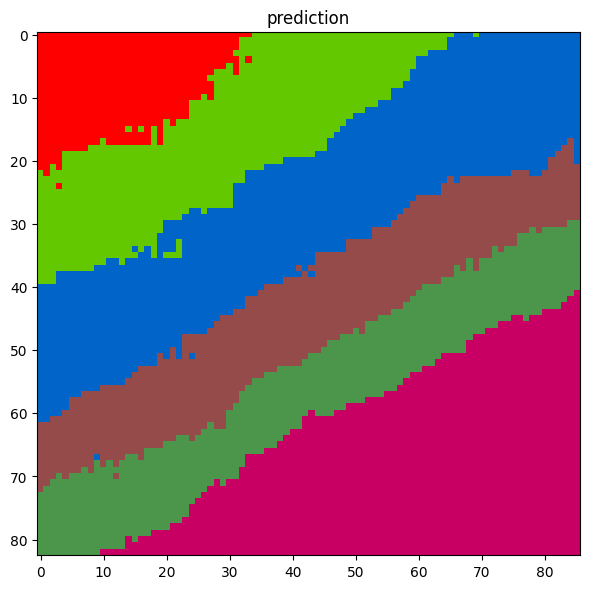

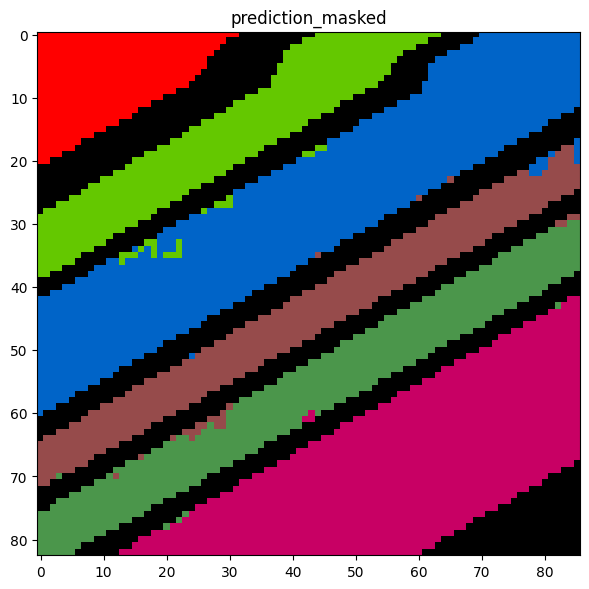

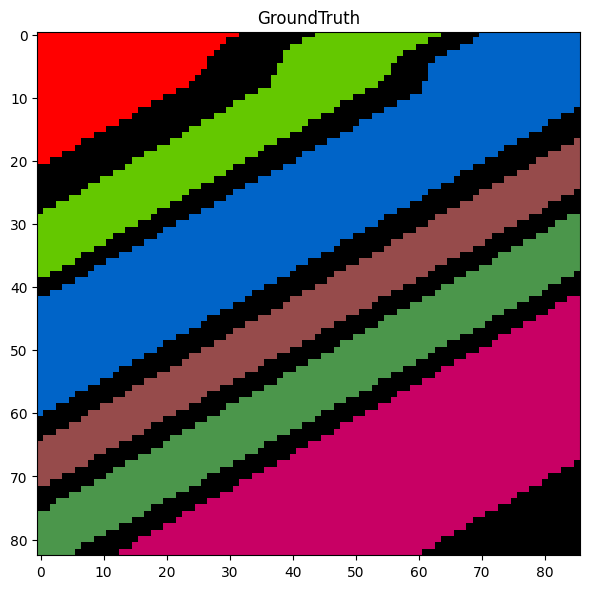

In [ ]:
spectral.imshow(classes=pred_map,title='prediction',figsize=(7,7))
spectral.imshow(classes=pred_map*(labels!=0),title='prediction_masked',figsize=(7,7))
spectral.imshow(classes=labels, title='GroundTruth', figsize=(7, 7))
spectral.save_rgb(os.path.join(SAVE_PATH,f"prediction.jpg"),pred_map,colors = spectral.spy_colors)
spectral.save_rgb(os.path.join(SAVE_PATH,f"prediction_masked.jpg"),pred_map*(labels!=0),colors = spectral.spy_colors)
spectral.save_rgb(os.path.join(SAVE_PATH,f"Groundtruth.jpg"),labels, colors=spectral.spy_colors)

## Evaluation

In [ ]:
test_pred = pred_map[test_gt!=0]
test_true = test_gt[test_gt!=0]

OA = accuracy_score(test_true,test_pred)
AA = recall_score(test_true,test_pred,average='macro')
kappa = cohen_kappa_score(test_true,test_pred)
report_log = F"OA: {OA}\nAA: {AA}\nKappa: {kappa}\n"
report_log += classification_report(test_true,test_pred,target_names=class_name,digits=4, zero_division=0)
print(report_log)
fp = open(os.path.join(SAVE_PATH,'classfication_report.txt'),'w+')
fp.writelines(report_log)
fp.close()

OA: 0.9852803738317757
AA: 0.9864776875755149
Kappa: 0.9815862763263187
                           precision    recall  f1-score   support

    Brocoli_green_weeds_1     1.0000    1.0000    1.0000       313
Corn_senesced_green_weeds     0.9972    0.9963    0.9967      1075
      Lettuce_romaine_4wk     0.9572    1.0000    0.9781       492
      Lettuce_romaine_5wk     0.9892    0.9795    0.9844      1221
      Lettuce_romaine_6wk     0.9617    0.9759    0.9688       540
      Lettuce_romaine_7wk     0.9936    0.9671    0.9802       639

                 accuracy                         0.9853      4280
                macro avg     0.9832    0.9865    0.9847      4280
             weighted avg     0.9855    0.9853    0.9853      4280



### Confusion Matrix

In [ ]:
unique_classes = np.unique(test_true)
class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
test_true_remapped = np.array([class_mapping[val] for val in test_true])
test_pred_remapped = np.array([class_mapping[val] for val in test_pred])


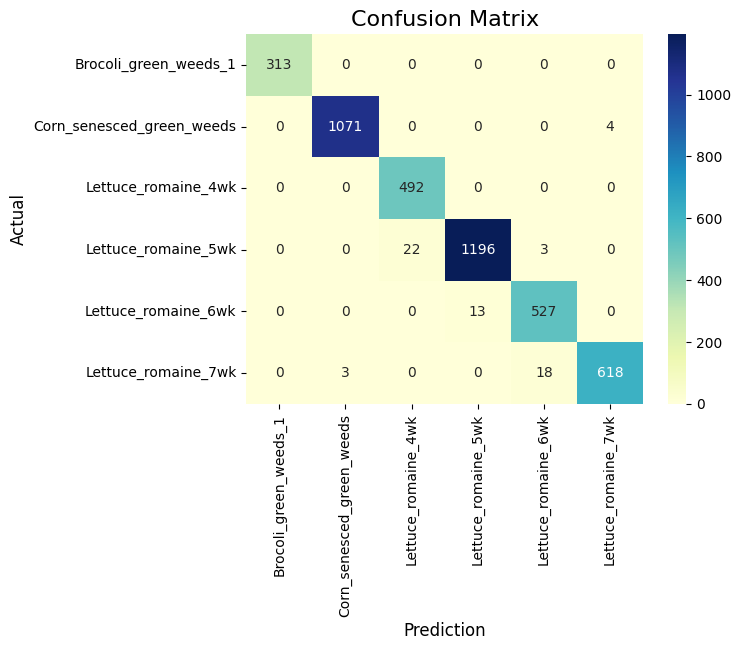

<Figure size 1000x1000 with 0 Axes>

In [ ]:
cm = confusion_matrix(test_true_remapped, test_pred_remapped)
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu', xticklabels=class_name, yticklabels=class_name)
plt.xlabel('Prediction',fontsize=12)
plt.ylabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.figure(figsize=(10, 10))
plt.show()
#plt.savefig(os.path.join(SAVE_PATH, 'confusion_matrix_with_values.png'))